In [1]:
import geopandas as gpd
import ipaddress
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio import plot, CRS
import rasterio.warp
import rasterio.features
import shapely
import shapely.geometry
import yaml
import time
from tqdm import tqdm
import os

from datetime import date, datetime, timedelta
from shapely import Point, Polygon, MultiPolygon, GeometryCollection, Geometry
from typing import Tuple

from aimlsse_api.client import GroundDataClient, SatelliteDataClient
from aimlsse_api.data import *

Make sure that the file `login.yml` exists. If not, create a new one and store your credentials for the [Copernicus OpenAPI Hub](https://scihub.copernicus.eu/dhus/#/home) in the following form:
```
username: <copernicus-username>
password: <copernicus-password>
```
The file is excluded from git to make sure that credentials are kept private.

In [2]:
login_config = yaml.safe_load(open('login.yml'))
username = login_config['username']
password = login_config['password']
copernicus_login = Credentials(username, password)

In [3]:
data_dir = 'data'
features_dir = os.path.join(data_dir, 'features')

In [4]:
datetime_from = datetime(2022, 8, 1)
datetime_to = datetime(2023, 2, 1)
assert datetime_to.date() > datetime_from.date(), f'Dates must be strictly ordered + \
    \nfrom:\t{datetime_from.date()}\nto:\t{datetime_to.date()}'

In [5]:
station_radius_of_influence = 8000.0 # meters

In [6]:
area_of_interest_df = gpd.read_file('input/USA-florida.geojson')
area_of_interest: MultiPolygon = area_of_interest_df.geometry.iloc[0]
print(type(area_of_interest))

<class 'shapely.geometry.multipolygon.MultiPolygon'>


In [7]:
def plot_florida(ax:plt.Axes, color:str):
    area_of_interest_df['geometry'].buffer(0).boundary.plot(ax=ax, facecolor=color, alpha=1.0, linewidth=0.1, zorder=1)

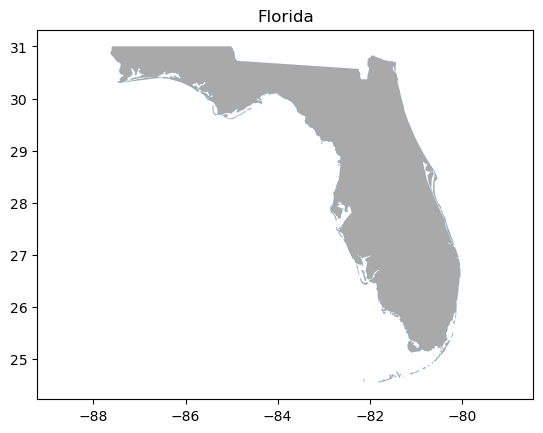

In [8]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Florida')
plot_florida(ax, 'darkgray')

In [9]:
ground_client = GroundDataClient(ipaddress.ip_address('127.0.0.1'), 8000)
stations_metadata = ground_client.queryMetadata(polygons=list(area_of_interest.geoms))
stations_metadata['name'] = stations_metadata['id']
stations_metadata.set_index('id', inplace=True)
print(f'Found {len(stations_metadata.index)} stations')

Found 1750 stations


In [10]:
def plot_stations(ax:plt.Axes, color:str):
    stations_metadata.plot(ax=ax, marker='.', color=color, markersize=1)

c:\Users\erikw\anaconda3\lib\site-packages\geopandas\plotting.py:642: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


<AxesSubplot: title={'center': 'Station-coverage of Florida'}>

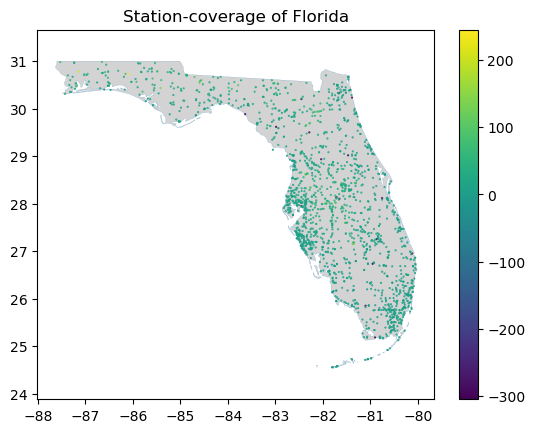

In [11]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Station-coverage of Florida')
plot_florida(ax, 'lightgray')
stations_metadata.plot('elevation', ax=ax, marker='.', markersize=1, colormap='viridis', legend=True)

In [12]:
satellite_client = SatelliteDataClient(ipaddress.ip_address('127.0.0.1'), 8010)
stations_to_sentinel_grid_cells_mapping: gpd.GeoDataFrame = satellite_client.queryContainingGeometry(
    stations_metadata[['name', 'geometry']])
sentinel_grid_cells: gpd.GeoDataFrame = stations_to_sentinel_grid_cells_mapping.drop_duplicates(subset=['cell_name']).copy()
print(f'Found {len(sentinel_grid_cells.index)} grid-cells')

Found 30 grid-cells


In [13]:
def plot_grid_cells(ax:plt.Axes):
    sentinel_grid_cells['geometry'].buffer(0).boundary.plot(ax=ax, edgecolor='black', alpha=0.5, linewidth=0.8, zorder=2)

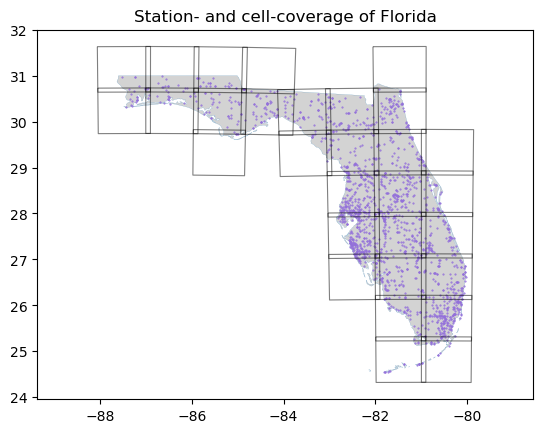

In [14]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Station- and cell-coverage of Florida')
plot_florida(ax, 'lightgray')
plot_stations(ax, 'mediumpurple')
plot_grid_cells(ax)

In [15]:
stations_per_grid_cell = stations_to_sentinel_grid_cells_mapping.groupby('cell_name')['name']
print(f'Average number of stations per grid cell: {stations_per_grid_cell.count().mean()}')

Average number of stations per grid cell: 67.7


In [16]:
sentinel_products_metadata_list = []
for cell_name in sentinel_grid_cells['cell_name']:
    sentinel_products_metadata_list += [satellite_client.queryProductsMetadata(datetime_from, datetime_to, copernicus_login,
        cell_name=cell_name
    )]
    time.sleep(1)
sentinel_products_metadata = pd.concat(sentinel_products_metadata_list)
sentinel_products_metadata['footprint'] = sentinel_products_metadata['footprint'].apply(lambda x: shapely.from_wkt(x))
sentinel_products_metadata['geometry'] = sentinel_products_metadata['footprint']
sentinel_products_metadata = gpd.GeoDataFrame(sentinel_products_metadata)
sentinel_products_metadata.set_crs(epsg=4326)
print(f'Found {len(sentinel_products_metadata.index)} entries')

Found 1409 entries


In [17]:
date_columns = list(filter(lambda x: 'date' in str(x), sentinel_products_metadata.columns.to_list()))
for col in date_columns:
    sentinel_products_metadata[col] = pd.to_datetime(sentinel_products_metadata[col], unit='ms')

In [18]:
sentinel_products_metadata[date_columns]

,generationdate,ingestiondate
32367204-eb40-459f-a1fe-d3af4b56738a,2023-01-29 18:18:06,2023-01-29 20:55:42.243
30c9d73b-baa7-4192-be04-0c214235f662,2023-01-27 20:08:00,2023-01-27 22:33:59.038
ebf55bf5-0809-44ed-8f44-08076a4b2dd9,2023-01-24 19:58:22,2023-01-24 22:52:29.946
97923ddb-5831-4e9e-9966-a55f1bc2e779,2023-01-22 18:25:13,2023-01-22 20:50:50.399
51377577-1922-4a0a-bb35-82f318c5d251,2023-01-19 18:18:53,2023-01-19 20:42:04.190
...,...,...
c55a2242-c5ff-4ed6-ae5b-29a3304aacd9,2022-08-21 21:16:54,2022-08-22 01:31:13.075
ee9c000f-c3a9-4180-b3b0-df5296ffcbe9,2022-08-16 19:43:30,2022-08-16 21:56:21.507
e1836471-7ee4-4541-9bf3-208b4c183da5,2022-08-11 21:19:46,2022-08-12 01:05:12.349
6738cc74-1862-4d92-a7c1-8e5571223be6,2022-08-06 19:45:24,2022-08-06 22:07:07.582


In [19]:
sentinel_products_metadata_per_cell = sentinel_products_metadata.groupby(['tileid'])
sentinel_grid_cells['num_entries'] = sentinel_grid_cells['cell_name'].apply(
    lambda name: len(sentinel_products_metadata_per_cell.get_group(name))
)

<AxesSubplot: title={'center': 'Number of sentinel-products per cell'}>

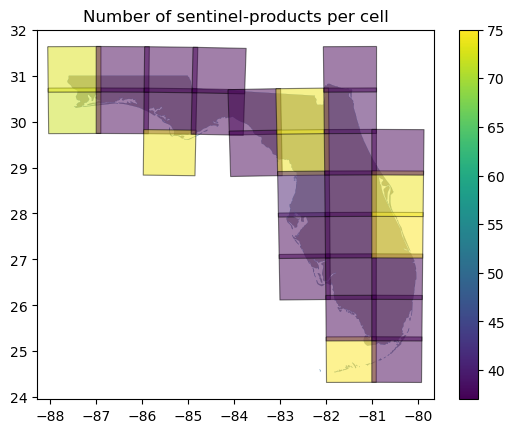

In [20]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Number of sentinel-products per cell')
plot_florida(ax, 'darkgray')
sentinel_grid_cells.plot('num_entries', ax=ax, markersize=0, edgecolor='black', facecolor='red',
    alpha=0.5, linewidth=0.8, legend=True, zorder=2)

In [21]:
products_sorted = sentinel_products_metadata.sort_values(by=['cloudcoverpercentage', 'generationdate'], ascending=[False, True])
products_range_selection = products_sorted[(products_sorted['cloudcoverpercentage'] > 50) & (products_sorted['cloudcoverpercentage'] < 70)].copy()
print(f'After selection, {len(products_range_selection.index)} of {len(sentinel_products_metadata.index)} products remain')

After selection, 133 of 1409 products remain


In [22]:
products_range_selection['geometry'] = products_range_selection['footprint']
remaining_grid_cells = products_range_selection.groupby(['tileid'])
print(f'After selection {len(remaining_grid_cells)} of {sentinel_grid_cells.shape[0]} grid cells remain')

After selection 30 of 30 grid cells remain


C:\Users\erikw\AppData\Local\Temp\ipykernel_18892\1127281880.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for label, data in remaining_grid_cells:


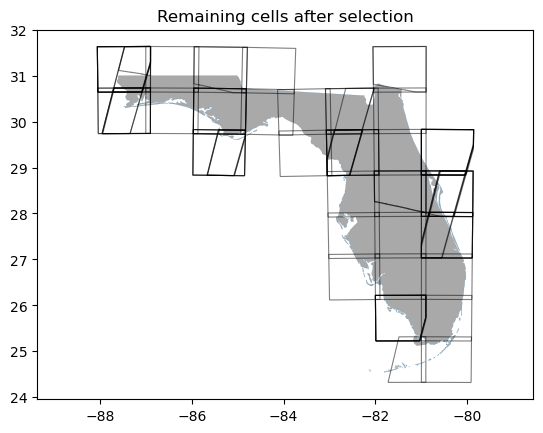

In [23]:
fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title('Remaining cells after selection')
plot_florida(ax, 'darkgray')
for label, data in remaining_grid_cells:
    gpd.GeoDataFrame(data.drop_duplicates(subset=['geometry'])).plot(ax=ax, markersize=0, edgecolor='black', facecolor='none', alpha=0.5, linewidth=0.8, zorder=2)

In [24]:
def reproject_point(point:Point, crs_from, crs_to) -> Point:
    return Point(rasterio.warp.transform_geom(crs_from, crs_to, point)['coordinates'])

def reproject_polygon(polygon:Polygon, crs_from, crs_to) -> Polygon:
    intermediate = rasterio.warp.transform_geom(crs_from, crs_to, polygon)['coordinates']
    return Polygon(*intermediate)

In [25]:
def sphere_of_influence(point:Point, radius:float, crs) -> Polygon:
    crs_intermediate = CRS.from_epsg(32616)
    return reproject_polygon(reproject_point(point, crs, crs_intermediate).buffer(radius),
        crs_intermediate, crs)

In [26]:
properties = [
    MetarProperty(MetarPropertyType.TEMPERATURE, UnitTemperature.CELSIUS),
    MetarProperty(MetarPropertyType.CURRENT_WEATHER),
    MetarProperty(MetarPropertyType.RECENT_WEATHER),
    MetarProperty(MetarPropertyType.SKY_CONDITIONS, UnitDistance.METERS),
    MetarProperty(MetarPropertyType.METAR_CODE)
]

relevant_time_range = timedelta(hours=1)

all_metars_list = []
for product_id, product in tqdm(products_range_selection.iterrows(), total=products_range_selection.shape[0]):
    # Query METAR data in relevant_time_range (R) like:
    # [obs_datetime - R/2, obs_datetime + R/2]
    half_time_range = relevant_time_range / 2.0
    product_datetime = product['generationdate']
    query_datetime_from = product_datetime - half_time_range
    query_datetime_to = product_datetime + half_time_range
    stations: gpd.GeoDataFrame = stations_metadata.loc[stations_per_grid_cell.get_group(product['tileid'])]
    product_footprint: shapely.MultiPolygon = product['footprint']
    stations = stations[stations['geometry'].apply(
        lambda x: sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).within(product_footprint)
    )]
    if not stations.empty:
        product_metars = ground_client.queryMetar(query_datetime_from, query_datetime_to, properties, stations['name'].to_list())
        product_metars['product_id'] = product_id
        all_metars_list += [product_metars]
all_metars = pd.concat(all_metars_list)
still_all_metars = all_metars
all_metars = all_metars[
    all_metars[str(MetarProperty(MetarPropertyType.SKY_CONDITIONS, UnitDistance.METERS))].apply(lambda x: len(x) > 0)
]
metars_per_product = all_metars.groupby(['product_id'])

100%|██████████| 133/133 [00:20<00:00,  6.63it/s]


In [27]:
products_filtered = sentinel_products_metadata.loc[metars_per_product.groups.keys()]
print('After filtering for the presence of cloud data in METARs and station containment in product footprint,\n'
      f'{len(products_filtered)} of {len(products_range_selection)} products remain '
      f'[{float(len(products_filtered)) / float(len(products_range_selection)) * 100.0:.1f} %]')

After filtering for the presence of cloud data in METARs and station containment in product footprint,
19 of 133 products remain [14.3 %]


In [28]:
products_filtered.index

Index(['18011c8a-cf74-4a6c-b3d1-868c45cf23d2',
       '20dffb09-4855-4b10-a7de-a72e4ac0c066',
       '23e1ec6a-510b-49a9-87c5-24d9e16cbbde',
       '32367204-eb40-459f-a1fe-d3af4b56738a',
       '3c266a4e-1e38-4ddd-85bd-2c67ed65669e',
       '4550a744-05f5-4c87-908d-b201ad815b13',
       '486b11ad-e34c-4da6-a3dc-a8ba615580e0',
       '4b35c34e-48bc-498e-9b53-523d87362053',
       '4c83a83f-111a-44cb-bedc-41d9b4e37918',
       '5eab681a-8644-4ead-a3d8-2c2e1439035c',
       '62718548-4c2e-463f-bedb-e8174bbc2274',
       '654e5311-9887-4199-875d-5e9f54f97773',
       '6f08c04b-3ac3-4012-830c-7f4d9e3036a8',
       '7ffda05f-fca0-4ae3-aad2-991f0f23b21d',
       '9a65ef19-9202-49af-ac86-70a7946183e6',
       'bc321ccd-fa2d-4626-acb3-451f51531803',
       'c0301dd2-6219-4c0d-8cee-30dfd345ac93',
       'd137bd4d-54c9-48cc-992a-24023b31a61e',
       'd47a3d26-c233-4dfc-8e6a-73d79529e886'],
      dtype='object')

In [29]:
metars_per_product.get_group(products_filtered.index[0])[['station', 'datetime', 'sky_conditions [M]']]

,station,datetime,sky_conditions [M]
0,COF,2023-01-25 19:55:00,"[DataSkyConditions(cover='CLR', height=None, c..."
1,MLB,2023-01-25 19:53:00,"[DataSkyConditions(cover='CLR', height=None, c..."
2,XMR,2023-01-25 19:55:00,"[DataSkyConditions(cover='CLR', height=None, c..."


<AxesSubplot: >

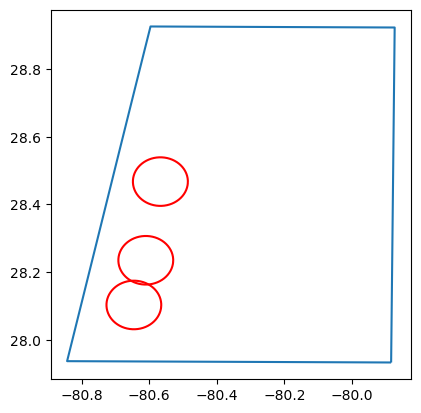

In [30]:
fig, ax = plt.subplots()
product_id_to_plot = products_filtered.index[0]
gpd.GeoDataFrame(pd.DataFrame(sentinel_products_metadata.loc[product_id_to_plot]).T).boundary.plot(ax=ax)
stations_metadata.loc[metars_per_product.get_group(product_id_to_plot)['station']]['geometry'].apply(
    lambda x: sphere_of_influence(x, station_radius_of_influence, CRS.from_epsg(4326)).boundary
).plot(ax=ax, color='red')

In [31]:
products_filtered['state'] = QueryStates.NEW
for product_id in tqdm(products_filtered.index):
    product_state = satellite_client.requestProduct(product_id, copernicus_login)
    products_filtered.at[product_id, 'state'] = product_state

100%|██████████| 19/19 [00:00<00:00, 240.17it/s]


In [32]:
products_filtered.groupby(['state'])['state'].count()

state
QueryStates.AVAILABLE    19
Name: state, dtype: int64

In [33]:
available_products = products_filtered[products_filtered['state'] == QueryStates.AVAILABLE]
print(f'{available_products.shape[0]} of {products_filtered.shape[0]} products are available [\
{float(available_products.shape[0]) / float(products_filtered.shape[0]) * 100.0:.1f} %]')

19 of 19 products are available [100.0 %]


In [34]:
available_products['generationdate']

18011c8a-cf74-4a6c-b3d1-868c45cf23d2   2023-01-25 19:34:30
20dffb09-4855-4b10-a7de-a72e4ac0c066   2023-01-29 18:18:06
23e1ec6a-510b-49a9-87c5-24d9e16cbbde   2022-09-13 21:28:09
32367204-eb40-459f-a1fe-d3af4b56738a   2023-01-29 18:18:06
3c266a4e-1e38-4ddd-85bd-2c67ed65669e   2023-01-19 18:18:53
4550a744-05f5-4c87-908d-b201ad815b13   2023-01-28 19:38:45
486b11ad-e34c-4da6-a3dc-a8ba615580e0   2023-01-03 17:58:26
4b35c34e-48bc-498e-9b53-523d87362053   2023-01-28 19:38:45
4c83a83f-111a-44cb-bedc-41d9b4e37918   2023-01-23 17:58:07
5eab681a-8644-4ead-a3d8-2c2e1439035c   2023-01-10 17:47:28
62718548-4c2e-463f-bedb-e8174bbc2274   2023-01-28 19:38:45
654e5311-9887-4199-875d-5e9f54f97773   2023-01-13 17:58:00
6f08c04b-3ac3-4012-830c-7f4d9e3036a8   2023-01-13 17:58:00
7ffda05f-fca0-4ae3-aad2-991f0f23b21d   2023-01-23 17:58:07
9a65ef19-9202-49af-ac86-70a7946183e6   2023-01-20 17:47:53
bc321ccd-fa2d-4626-acb3-451f51531803   2023-01-04 18:20:28
c0301dd2-6219-4c0d-8cee-30dfd345ac93   2023-01-23 17:58:

In [36]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
os.makedirs(features_dir, exist_ok=True)
ctr = 0
for product_id, row in tqdm(available_products.iterrows(), total=available_products.shape[0]):
    if any(filter(lambda path: path.startswith(product_id), os.listdir(features_dir))):
        # Skip existing files and directories
        ctr += 1
        continue
    if product_id not in metars_per_product.groups.keys():
        # If no data is available for a tile, skip it
        continue
    stations: pd.Series = metars_per_product.get_group(product_id)['station']
    stations = stations.drop_duplicates()
    stations_with_geometry = stations_metadata[stations_metadata['name'].isin(stations)].copy()
    stations_with_geometry['name'] = stations_with_geometry.index
    stations_with_geometry = stations_with_geometry[['name', 'geometry']]
    stations_gdf = gpd.GeoDataFrame(stations_with_geometry)
    stations_gdf.set_crs(crs='EPSG:4326', inplace=True)
    satellite_client.extractFeatures(product_id, station_radius_of_influence, bands, stations_gdf, features_dir)
    ctr += 1
print(ctr)

100%|██████████| 19/19 [00:50<00:00,  2.67s/it]

19


Create a numpy array from METAR data for a single product:

In [37]:
from zipfile import ZipFile
import rasterio
from rasterio import plot, CRS
import rasterio.warp
import rasterio.features
from pathlib import Path
from typing import Dict, List, Tuple
import math

In [45]:
selected_product_id = available_products.iloc[0]['uuid']
print(selected_product_id)

18011c8a-cf74-4a6c-b3d1-868c45cf23d2


In [46]:
product_path = os.path.join(features_dir, selected_product_id)
if not os.path.isdir(product_path):
    product_zip_path = product_path + '.zip'
    if not os.path.exists(product_zip_path):
        raise FileExistsError(f'Could not find directory {product_path} or zip-file {product_zip_path}')
    with ZipFile(product_zip_path) as zip_file:
        zip_file.extractall(features_dir)
    os.remove(product_zip_path)

In [47]:
bands = os.listdir(product_path)
print(bands)

['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']


In [48]:
image_drivers = {
    'jp2': 'JP2OpenJPEG'
}

In [49]:
selected_tile = sentinel_products_metadata.loc[selected_product_id]['tileid']
print(f'Tile {selected_tile}')
selected_metars: pd.DataFrame = metars_per_product.get_group(selected_product_id)
selected_stations = selected_metars['station'].drop_duplicates()
print(f'Stations {selected_stations.to_list()}')

Tile 17RNM
Stations ['COF', 'MLB', 'XMR']


In [50]:
bands_with_images: Dict[str, Dict[str, rasterio.DatasetReader]] = {}
for band in bands:
    band_path = os.path.join(product_path, band)
    station_files = os.listdir(band_path)
    bands_with_images[band] = {}
    print(f'Band {band} has station-files: {station_files}')
    for station_file in station_files:
        station_image_path = os.path.join(band_path, station_file)
        station_image = rasterio.open(station_image_path, driver=image_drivers[Path(station_image_path).suffix[1:]])
        station = Path(station_image_path).stem
        bands_with_images[band][station] = station_image

Band B1 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B10 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B11 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B12 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B2 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B3 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B4 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B5 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B6 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B7 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B8 has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']
Band B8A has station-files: ['COF.jp2', 'MLB.jp2', 'TIX.jp2', 'TTS.jp2', 'XMR.jp2']


Selected station COF with data:
station                                                             COF
datetime                                            2023-01-25 19:55:00
temperature [C]                                                    29.5
current_weather                                                      []
recent_weather                                                       []
sky_conditions [M]    [DataSkyConditions(cover='CLR', height=None, c...
metar_code            KCOF 251955Z AUTO 19016KT 10SM CLR 30/17 A2990...
product_id                         18011c8a-cf74-4a6c-b3d1-868c45cf23d2
Name: 0, dtype: object
Selected band B2


<AxesSubplot: title={'center': 'Station COF - Band B2'}>

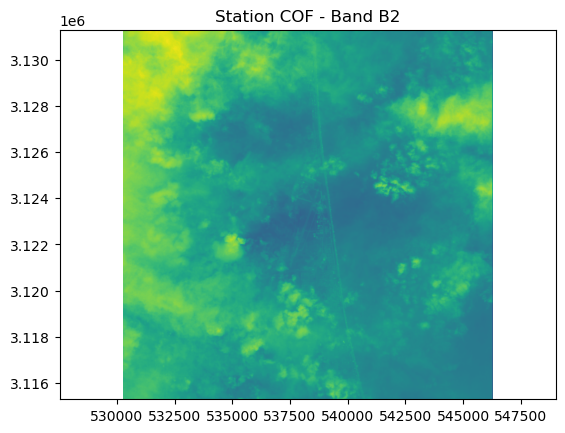

In [51]:
station = selected_stations[0]
station_metadata = stations_metadata.loc[station]
station_metar = selected_metars[selected_metars['station'] == station].iloc[0]
print(f'Selected station {station} with data:\n{station_metar}')
band = 'B2'
print(f'Selected band {band}')

data = bands_with_images[band][station]

fig, ax = plt.subplots()
ax.set_aspect('equal', 'datalim')
ax.set_title(f'Station {station} - Band {band}')
plot.show(data, ax=ax)

In [52]:
data.count

1

In [53]:
data.crs

CRS.from_epsg(32617)

In [55]:
print(data.res)
assert data.res[0] == data.res[1]
resolution = data.res[0]
print(f'Spatial resolution is {resolution} meters per pixel')

(10.0, 10.0)
Spatial resolution is 10.0 meters per pixel


In [56]:
data.shape

(1601, 1601)

In [57]:
station_location: Point = stations_metadata.loc[station]['geometry']
print(f'{CRS.from_epsg(4326)}: {station_location}')
station_location = reproject_point(station_location, CRS.from_epsg(4326), data.crs)
print(f'{data.crs}: {station_location}')

EPSG:4326: POINT (-80.60999 28.23496)
EPSG:32617: POINT (538263.4336502262 3123292.1496769427)


In [59]:
data.bounds

BoundingBox(left=530260.0, bottom=3115290.0, right=546270.0, top=3131300.0)

In [60]:
station_location_relative = Point(
    (data.bounds.right - station_location.x) / (data.bounds.right - data.bounds.left),
    (data.bounds.top - station_location.y) / (data.bounds.top - data.bounds.bottom)
)
print(station_location_relative)
station_location_for_shape = Point(
    station_location_relative.x * data.shape[0],
    station_location_relative.y * data.shape[1]
)
print(station_location_for_shape)

POINT (0.5000978357135405 0.5001780339198794)
POINT (800.6566349773783 800.7850323057269)


In [61]:
fov_angle = 120.0 # degrees
max_cloud_height = 20000.0 # meters
height_delta = max_cloud_height - station_metadata['elevation']
print(f'height_delta: {height_delta}')
influence_radius = math.tan(fov_angle * 0.5) * height_delta
print(f'For a FOV angle of {fov_angle}° and a max cloud-height of {max_cloud_height} meters, the radius of influence is {influence_radius:.1f} meters')

height_delta: 19997.0
For a FOV angle of 120.0° and a max cloud-height of 20000.0 meters, the radius of influence is 6399.8 meters


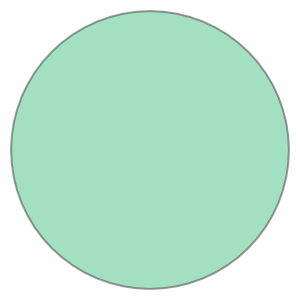

In [62]:
area_of_validity_mask = station_location_for_shape.buffer(6000.0 / resolution)
area_of_validity_mask

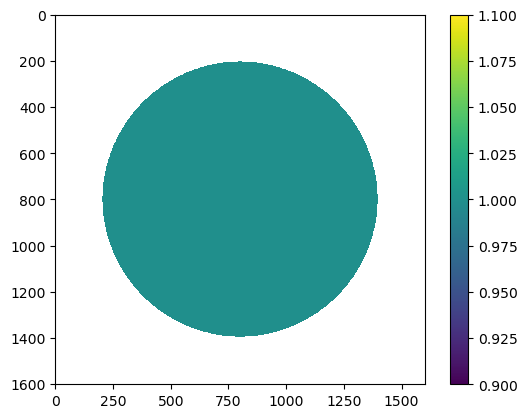

In [63]:
img = rasterio.features.rasterize([area_of_validity_mask], out_shape=data.shape, fill=np.nan)
plt.imshow(img)
plt.colorbar()

In [64]:
img

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [65]:
selected_property = str(properties[0])
print(f'{selected_property}: {station_metar[selected_property]}')

temperature [C]: 29.5


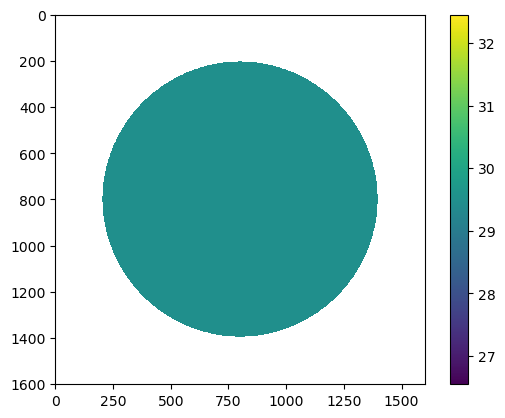

In [66]:
output_data_layer = img * station_metar[selected_property]
plt.imshow(output_data_layer)
plt.colorbar()

In [67]:
output_data_layer

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

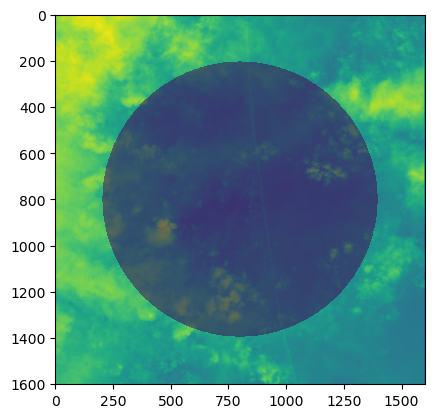

In [68]:
input_data_layer: np.ndarray = data.read(1)

fig, ax = plt.subplots()
ax.imshow(input_data_layer / np.linalg.norm(input_data_layer))
ax.imshow(output_data_layer, alpha=0.5)

In [69]:
np.dstack((input_data_layer, output_data_layer))

array([[[1.000e+00,       nan],
        [0.000e+00,       nan],
        [0.000e+00,       nan],
        ...,
        [0.000e+00,       nan],
        [3.000e+00,       nan],
        [1.000e+00,       nan]],

       [[6.257e+03,       nan],
        [6.251e+03,       nan],
        [6.276e+03,       nan],
        ...,
        [3.478e+03,       nan],
        [3.499e+03,       nan],
        [0.000e+00,       nan]],

       [[6.213e+03,       nan],
        [6.259e+03,       nan],
        [6.247e+03,       nan],
        ...,
        [3.499e+03,       nan],
        [3.515e+03,       nan],
        [4.000e+00,       nan]],

       ...,

       [[4.993e+03,       nan],
        [5.013e+03,       nan],
        [5.036e+03,       nan],
        ...,
        [3.251e+03,       nan],
        [3.220e+03,       nan],
        [0.000e+00,       nan]],

       [[5.010e+03,       nan],
        [5.032e+03,       nan],
        [5.023e+03,       nan],
        ...,
        [3.240e+03,       nan],
        [3.226e+03